In [77]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops


In [78]:
from tensorflow.examples.tutorials.mnist import input_data
fashion_mnist = input_data.read_data_sets("data/fashion",
                                          one_hot=False)

Extracting data/fashion/train-images-idx3-ubyte.gz
Extracting data/fashion/train-labels-idx1-ubyte.gz
Extracting data/fashion/t10k-images-idx3-ubyte.gz
Extracting data/fashion/t10k-labels-idx1-ubyte.gz


In [79]:
fashion_mnist.test.labels[0]

9

In [80]:
print("Training set (images) shape: {shape}".format(shape=fashion_mnist.train.images.shape))
print("Training set (images) shape: {shape}".format(shape=fashion_mnist.test.images.shape))

Training set (images) shape: (55000, 784)
Training set (images) shape: (10000, 784)


In [81]:
sample = fashion_mnist.train.images.reshape(fashion_mnist.train.images.shape[0],28,28,1)

###  Checking if classes are balanced

(array([5543., 5444., 5496., 5499., 5512., 5507., 5507., 5488., 5510.,
        5494.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

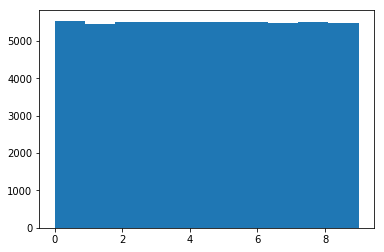

In [82]:
plt.hist(fashion_mnist.train.labels,bins=10)

In [83]:
def create_conv_layer(input_x, num_channels,filter_size,num_filter):
    weights = create_weights(shape=[filter_size,
                                    filter_size, num_channels,
                                    num_filter])
    biases = create_biases(num_filter)
    layer = tf.nn.conv2d(input=input_x,
                        filter=weights,
                        strides=[1,1,1,1],
                        padding = 'SAME')
    layer = tf.add(layer,biases)    
    layer = maxpool(layer)
    layer = tf.nn.relu(layer)
    
    return layer


def fc_layer(input,num_inputs,num_outputs):   
    weights = create_weights(shape=[num_inputs, num_outputs])
    biases = create_biases(size=num_outputs)
    layer = tf.matmul(input,weights)+biases
    return layer

def flatten_layer(layer):
    return tf.contrib.layers.flatten(layer)

def maxpool(x,k=2):
    return tf.nn.max_pool(x,ksize=[1,k,k,1],
                          strides = [1,k,k,1],padding='SAME')
    
def create_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))
 
def create_biases(size):
    return tf.Variable(tf.constant(0.05, shape=[size]))

In [84]:
def model_fn(features,labels,mode,params):
    x = features
    y=labels

    writer =tf.summary.FileWriter("./summary")
    accuracy_summary = tf.Summary()
    cost_summary = tf.Summary()
    layer = create_conv_layer(x,num_channels=1,filter_size=10,num_filter=2)
    layer = create_conv_layer(layer,2,5,2)
    layer = create_conv_layer(layer,2,5,2)
    layer = create_conv_layer(layer,2,5,2)
    layer=flatten_layer(layer)
    layer=flatten_layer(layer)
    layer=flatten_layer(layer)
    layer=flatten_layer(layer)
   
    final = fc_layer(layer,8,10)
    
    y_pred = tf.nn.softmax(final,name="y_pred")
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        predictions =y_pred
        return tf.estimator.EstimatorSpec(mode, predictions=predictions)
    
    
    y_pred_cls = tf.argmax(y_pred,dimension=1)    
    with tf.name_scope("cost_function") as scope:    
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
             logits=y_pred,labels=y)
        cost = tf.reduce_mean(cross_entropy)
        cost_summary = tf.summary.scalar("cost",cost)

    with tf.name_scope("accuracy") as scope:
        corr_pred = tf.equal(
            tf.argmax(y,1),
           y_pred_cls
        )
        acc = tf.reduce_mean(tf.cast(corr_pred,tf.float32))
        accuracy_summary = tf.summary.scalar("tr_acc",acc)
        metrics = \
        {
            "accuracy": tf.metrics.accuracy( tf.argmax(y,1), y_pred_cls)
        }
        
        if mode == tf.estimator.ModeKeys.EVAL:
            return tf.estimator.EstimatorSpec(mode,loss=cost,eval_metric_ops=metrics)


    with tf.name_scope("training") as scope:
        optimizer = tf.train.AdamOptimizer(
            learning_rate=params["learning_rate"]).minimize(cost)
 
    logging_hook = tf.train.LoggingTensorHook({"loss" : cost}, every_n_iter=1)
    
    summary_hook = tf.train.SummarySaverHook(
    save_steps =1,
    output_dir='./summary',
    summary_op=tf.summary.merge_all())
        
    spec = tf.estimator.EstimatorSpec(
            mode=mode,
            loss=cost,
            train_op=optimizer,
            eval_metric_ops=metrics,
        training_hooks=[summary_hook])
    
    return spec
    

In [85]:
def input_fn():
    images = fashion_mnist.train.images
    labels =fashion_mnist.train.labels
    print(len(images))
    
    labels = tf.convert_to_tensor(labels) 
    labels =tf.one_hot(labels,depth=10)

    data = images.reshape(images.shape[0],28,28,1)
    data = tf.convert_to_tensor(data)
    
    dataset = tf.data.Dataset.from_tensor_slices(
            (data, labels))
    
    dataset=dataset.batch(100)
    features, labels = dataset.make_one_shot_iterator().get_next()    
    return features,labels


def eval_fn():
    images = fashion_mnist.test.images
    labels =fashion_mnist.test.labels
    
    labels = tf.convert_to_tensor(labels) 
    labels =tf.one_hot(labels,depth=10)

    data = images.reshape(images.shape[0],28,28,1)
    data = tf.convert_to_tensor(data)
    
    dataset = tf.data.Dataset.from_tensor_slices(
            (data, labels))

    dataset=dataset.batch(100)
    features, labels = dataset.make_one_shot_iterator().get_next()

    
    return features,labels



In [86]:
l_rate=0.1
for epoch in range(0,10):
    l_rate=0.1/10
    tf.logging.set_verbosity(tf.logging.ERROR)
    params = {"learning_rate": l_rate}
    run_config = tf.estimator.RunConfig()
    model = tf.estimator.Estimator(model_fn=model_fn,
                                   params=params,
                                   config = run_config,
#                                    warm_start_from="./summary",
                                   model_dir="./summary")
    model.train(input_fn=input_fn,steps=10)
    model.evaluate(input_fn=eval_fn,steps=10)

55000
55000


KeyboardInterrupt: 

In [ ]:
def pred_input(images):    
    data = images.reshape(images.shape[0],28,28,1)
    data = tf.convert_to_tensor(data)
    dataset = tf.data.Dataset.from_tensors(data)    
    return dataset


In [ ]:
p_images = fashion_mnist.test.images[0:2]
l_labels = fashion_mnist.test.labels[0:2]
predictions = model.predict(input_fn=lambda: pred_input(p_images))
for idx,p in enumerate(list(predictions)):
    print("Expected:",l_labels[idx])
    print("Probabilities:",p)
    print("Predicted class: ",np.argsort(p)[::-1][0])
    print()

In [ ]:
sample = fashion_mnist.test.images[0].reshape(28,28)
print(sample.shape)
plt.imshow(sample,cmap='Greys')

In [ ]:
*